<div align="center">
<b>0.0 | Initial Setup</b>
</div>

### 0.1 Requirements and Installation

The following libraries are required to run this notebook. The environment.yml file is provided to create a conda/mamba environment with the required libraries. Within it are the required packages and their versions.

To install the environment, navigate to the directory of this file and run the following command in the terminal:
```bash
conda env create --name cuba_classification --file=environment.yml
```

Then to activate the environment you can run:
```bash
conda activate cuba_classification
```

You can now use the `cuba_classification` environment to run the code in this notebook.

In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Sci-Kit Learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# CART
from sklearn.tree import DecisionTreeClassifier

# random forest
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost import XGBClassifier

### 0.2 Google Earth Engine Authentication

To run the code, you will need to a Google Earth Engine account. When the notebook code below is first ran on your computer, it will open a browser window asking you to authenticate your account. Once you have done this, it will give you an access token which you can copy and paste into this notebook (where it requests it). You only need to do this once.

In [2]:
ee.Authenticate()
ee.Initialize()

### 0.3 Recomputing the Models

Due to long runtimes during model training and preprocessing, the various models and some of the preprocessed data is saved in the `models` and `temporary` folders. If you want to re-run *all* the code, you can delete these folders and re-run the notebook. **Note: This will take multiple hours**. If you want to re-run only parts of the code, you can delete the specific files you want to re-calculate.

---

# Unveiling Cuban Landscapes: An Optimized Supervised Learning Model for Effective Land Cover Monitoring

<p style="text-align: center;">Student Number: 23215050</p>
<p style="text-align: center;">Word Count: 2193</p>
<p style="text-align: center;">Created for CASA0006: Data Science for Spatial Systems</p>
<p style="text-align: center;">MSc. Urban Spatial Science — University College London (UCL)</p>
<p style="text-align: center;">April 2024</p>

<div align="center">

|
[1.0 Introduction](#10--Introduction) | 
[2.0 Research Question](#20--research-question) | 
[3.0 Presentation of Data](#30--presentation-of-data) | 
[4.0 Methodology](#40--methodology) | 
[5.0 Results](#50--Results) | 
[6.0 Conclusion](#60--conclusion) |

</div>

## 1.0 | Introduction

Cuba's land cover, as recorded by (Galford et al., 2018), is primarily agricultural. However, this landscape is likely to change due to the country's increasing foreign investment and tourism. Drastic changes to Cuba’s land have occurred before, such as through the transition from large-scale to small-scale farming following the end of Soviet subsidies (Machado, 2018). More specifically, there has been a long-term process of land reform in Cuba, which has seen a shift from peasant collectivization to re-peasantization (Botella-Rodríguez and González-Esteban, 2021). This transition has led to significant changes in agricultural land use. An increase in foreign and national investments in tourism may also lead to a greater expansion of urban areas in recent times, such as through the creation of tourist enclaves (González et al., 2014). These studies collectively suggest that Cuba's land cover has been changing, particularly in its agricultural and urban areas, due to both historical and recent factors. However, as we will further discuss, existing models for monitoring land cover changes in Cuba may fail to adequately detect these changes.

Complex models for determining the land cover of specific countries can be useful tools for understanding changes in the natural and built environments of a nation (Marston et al., 2023). Existing Cuban land cover models are particularly beneficial for environmental conservation efforts (Gebelein, 2012; Galford et al., 2018; Nuñez-Penichet, Maita-Chamba and Soberón, 2023). However, existing land cover maps for Cuba were created as secondary points of information for a different research focus, did not document any process for optimizing the output of the classification models, and remain unavailable.

Large remote sensing datasets, such as those created by the Wildlife Conservation Society (WCS) and the Food and Agriculture Organization (FAO), have been used for understanding the Cubas changing landscapes (Machado, 2018). The FAO dataset uses data provided from the NASA MODIS Land Cover Collection, as well as the European Space Agency’s (ESA) WorldCover project, both of which provide land cover estimates that cover the whole of Cuba. However, each of these existing estimates have notable flaws.

- WCS' Human Footprint dataset measures human impact but overlooks land cover variations, while offering only 300-meter resolution. (Sanderson et al., 2002, 2022).
- NASA’s MODIS dataset only has a resolution of 500 meters, significantly lower than Landsat and Sentinel missions' higher resolutions of up to 15 and 10 meters, respectively (Friedl and Sulla-Menashe, 2019; USGS, no date c).
- ESA's WorldCover project provides 10-meter resolution estimates for the whole world for 2021 and 2022 but struggles with accuracy due to global project ambitions, achieving only 76.7% accuracy with its improved 2021 v200 model (Zanaga et al., 2021, 2022).

Existing global models, while vital for broader analyses, often lack precision for specific regions like Cuba. This underscores the importance of localized initiatives for accurate land cover assessments.

By creating an accurate model for predicting land cover in Cuba (that can be run on different years), we can better understand what changes are happening and where on the island.



## 2.0 | Research Question

How can we develop an optimized and accurate land cover classification model tailored to the unique landscape of Cuba to effectively monitor and understand the dynamic changes occurring in agricultural and urban areas of the island? From this model, are we able to detect any significant changes on a portion of Cuba’s land cover over the past 10 years?


## 3.0 | Presentation of Data

#### 3.1 Data Collection

In [46]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']
LABEL = ['type']

CLASSES = [0, 1, 2, 3, 4, 5]
N_CLASSES = len(CLASSES)

CLASS_VALUES = {
    'urban': 0, 
    'deep_ocean': 1, 
    'shallow_waters': 2, 
    'agriculture': 3,
    'barren': 4,
    'forest': 5
}

class_labels = {v: k for k, v in CLASS_VALUES.items()}

# PALETTE = ['#f0027f', '#386cb0', '#ADD8E6', '#fdc086', '#ffff99', '#008080']
PALETTE = ['#e31a1c', '#1f78b4', '#a6cee3', '#fb9a99', '#b2df8a', '#33a02c']

NUM_SAMPLES_PER_CLASS = 10_000

We are using data collected from by the Landsat 8 satellite. This data is collected by the United States Geological Survey (USGS) and is available through Google Earth Engine (GEE).

In [4]:
# Define the image collection for the Landsat 8 data (We will be using the `ee` library to access the Landsat data.)
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")


Cuba's territorial seas boundaries were collected from the MarineRegions database, managed by the Flanders Marine Institute. This was used to create a cutout of the island of Cuba from the global satellite dataset.

In [5]:
# Load the Cuba territorial seas shapefile (inside the data folder) using geopandas
cuba_territorial_seas = gpd.read_file(os.path.join('data', 'eez_12nm.zip'))


# The shapefile has only the shape of the territorial seas of Cuba, so we need to fill in the ring to capture
# the whole island.
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

cuba_territorial_seas = cuba_territorial_seas.geometry.apply(lambda p: close_holes(p))

# Convert GeoPandas object to Earth Engine geometry
cuba_json = cuba_territorial_seas.to_json()
geometry_cuba = ee.FeatureCollection(json.loads(cuba_json))

Cannot find header.dxf (GDAL_DATA is not defined)


To remove clouds and atmospheric disturbances that can affect satellite image quality, the `mask_clouds()` function was created.

In [6]:
# Define a function to mask clouds for Landsat 8 images
def mask_clouds(image):
    '''
    This function uses a quality assessment band ('QA_PIXEL') where specific bits indicate the presence of clouds or their shadows. 
    The function creates masks for these bits and applies them to the image, effectively filtering out the clouds and their shadows. 
    The resulting image, with clouds removed, is then returned.
    '''
    L8cloudShadowBitMask = 1 << 3
    L8cloudsBitMask = 1 << 4
    L8Qa = image.select('QA_PIXEL')
    L8mask = L8Qa.bitwiseAnd(L8cloudShadowBitMask).eq(0) \
             .And(L8Qa.bitwiseAnd(L8cloudsBitMask).eq(0))
    return image.updateMask(L8mask)

We take our satellite image collection, clip out the island of Cuba using the previously loaded territorial seas boundary, mask out the clouds, and then filter the images to only include those from 2023. We then take the median of these images to create a composite image of Cuba for 2023. By taking the median, we reduce the effect of outliers in the data, such as those caused by atmostpheric disturbances or seasonal changes.

In [7]:
# Filter the Landsat images
landsat_cuba = image_collection.filterBounds(geometry_cuba).map(mask_clouds)

# Define start and end dates
start_date = ee.Date('2023-01-01')
end_date = ee.Date('2023-12-31')

# Filter by date
landsat_cuba = landsat_cuba.filterDate(start_date, end_date)

# Get median image, only for the geometry of cuba, and for bands with 30m resolution
median_image = landsat_cuba.median().clip(geometry_cuba).select(FEATURES)

Using bands 2, 3, and 4 (which correspond to the blue, green, and red bands of the satellite imagery), we create a true color image of Cuba for 2023. This image is then displayed using folium to create an iteractive map.

In [8]:
# Display the map
mapid = median_image.getMapId({'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']})

# Create a Folium map object
map = folium.Map(location=[22, -80], zoom_start=7)

# Add the Landsat image layer
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Landsat Image',
).add_to(map)

# Add layer control
folium.LayerControl().add_to(map)

# Display the map
map

### 3.2 Subset Selection

Due to size and computational constraints, running models on the entire island of Cuba isn't feasible for this assignment. Instead, we'll visualize results using a subset: Isla de la Juventud, Cuba's second largest island. Training and testing will encompass the entire island, ensuring that model application to the subset remains representative. Isla de la Juventud, situated southwest of the main island, contains portions of all land covers of interest, making it ideal for result visualization.

In [9]:
# Define the geometry for the Isla de la Juventud
geometry_idlj = ee.Geometry.Polygon(
    [[[-83.21494438818296,21.4],
      [-82.5032363193353,21.4],
      [-82.5032363193353,21.93872306614785],
      [-83.21494438818296,21.93872306614785]]])

# Get median image, only for the geometry of Isla de la Juventud
# We will use this image for visually displaying the model results
median_idlj = landsat_cuba.median().clip(geometry_idlj).select(FEATURES)

In [10]:
# Function to split geometry into smaller subregions
def split_geometry(geometry, num_parts):
    '''
    For running our models on the subset, we must convert the Google Earth Engine image to an array that can be used by the scikit-learn library. 
    Unfortunately, there is no direct way to do this. 
    Instead, we must download the image from Earth Engine as a raster file and then read it back in as an array. 
    Even though we are only working with a subset of the country, Google's download limits still prevent images of this size from being downloaded. 
    To get around this, the function split_geometry() was created. This function takes in a geometry and splits it into smaller portions that can be downloaded separately.
    '''
    bounds = geometry.bounds().getInfo()
    # Extracting bounding coordinates
    xmin = bounds['coordinates'][0][0][0]
    ymin = bounds['coordinates'][0][0][1]
    xmax = bounds['coordinates'][0][2][0]
    ymax = bounds['coordinates'][0][2][1]
    width = (xmax - xmin) / num_parts
    height = (ymax - ymin) / num_parts

    subgeometries = []
    for i in range(num_parts):
        for j in range(num_parts):
            subgeometry = box(xmin + i * width, ymin + j * height,
                              xmin + (i + 1) * width, ymin + (j + 1) * height)
            subgeometries.append(subgeometry)

    return subgeometries

The following code is able to take the image object of the Isla de la Juventud, split it into smaller subsections, download each subsection, load it back in as an array, and then concatenate the arrays back together to create the full image raster array. This final array is saved so that it can be loaded in later without needing to re-download the GEE images. 

In [11]:
'''
The following code is able to take the image object of the Isla de la Juventud, 
split it into smaller subsections, download each subsection, load it back in as an array, 
and then stitch the arrays back together to create the full image raster array. 
This final array is saved so that it can be loaded in later without needing to re-download the GEE images.
'''

# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_path = os.path.join(temp_dir, "ildj_median_2023_merged.tif")
if not os.path.exists(output_path):
    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_idlj, num_parts=3)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(median_idlj, filename=output_filename, region=geojson_geometry, scale=30)
        print(f"Exporting {output_filename}...")

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif") for i in range(len(subgeometries))]
    datasets = [rasterio.open(file) for file in output_files]
    merged, transform = merge(datasets)

    # Close the datasets
    for dataset in datasets:
        dataset.close()

    # Update the metadata
    profile = datasets[0].profile
    profile.update({"height": merged.shape[1], "width": merged.shape[2], "transform": transform})

    # Output merged image
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(merged)

    # Delete smaller TIFF files
    for file in output_files:
        os.remove(file)
else:
    print("Found existing ildj_median_2023_merged.tif file. Using that instead.")

Found existing ildj_median_2023_merged.tif file. Using that instead.


In [12]:
median_image_raster = rasterio.open(output_path)
height = median_image_raster.height
width = median_image_raster.width
shape = (height, width)

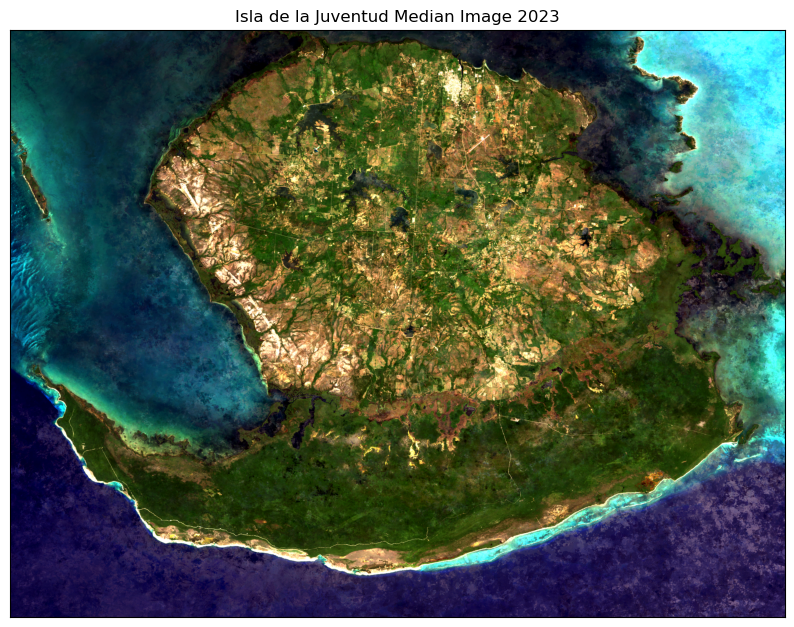

In [50]:
'''
With the image array loaded in, we can visualize the resulting image of the Isla de la Juventud. 
We once again use the bands 2, 3, and 4 to create a true color image of the island, 
but use the library EarthPy to stretch each band's histogram to improve the contrast.
'''

# Plot median_image_raster
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ep.plot_rgb(median_image_raster.read([4, 3, 2]), ax=ax, title="Isla de la Juventud Median Image 2023", stretch=True)
plt.show()

Although we used bands 2, 3, and 4 for visualization, we will be using bands 1-7 and 9 for the classification model.

In [38]:
band_info = {
    "Band": ["Band 1", "Band 2", "Band 3", "Band 4", "Band 5", "Band 6", "Band 7", "Band 9"],
    "Type": ["Coastal/Aerosol", "Blue", "Green", "Red", "Near Infrared", "Shortwave Infrared 1", "Shortwave Infrared 2", "Cirrus"],
    "Wavelength Range": ["0.43 - 0.45 µm", "0.45 - 0.51 µm", "0.53 - 0.59 µm", "0.64 - 0.67 µm", "0.85 - 0.88 µm", "1.57 - 1.65 µm", "2.11 - 2.29 µm", "1.36 - 1.38 µm"]
}

band_info_df = pd.DataFrame(band_info)

print("Band Information:")
print(band_info_df)

Band Information:
     Band                  Type Wavelength Range
0  Band 1       Coastal/Aerosol   0.43 - 0.45 µm
1  Band 2                  Blue   0.45 - 0.51 µm
2  Band 3                 Green   0.53 - 0.59 µm
3  Band 4                   Red   0.64 - 0.67 µm
4  Band 5         Near Infrared   0.85 - 0.88 µm
5  Band 6  Shortwave Infrared 1   1.57 - 1.65 µm
6  Band 7  Shortwave Infrared 2   2.11 - 2.29 µm
7  Band 9                Cirrus   1.36 - 1.38 µm


These bands were chosen since they all have 30 meter resolution.
Plotting the bands separately aids in comprehending the data. Bands like 5, 6, and 7 vividly outline the island's shape. However, distinguishing land cover types through visual analysis alone is challenging. Hence, employing a machine learning model is required to classify land cover and extract insights from band interactions beyond visual perception.

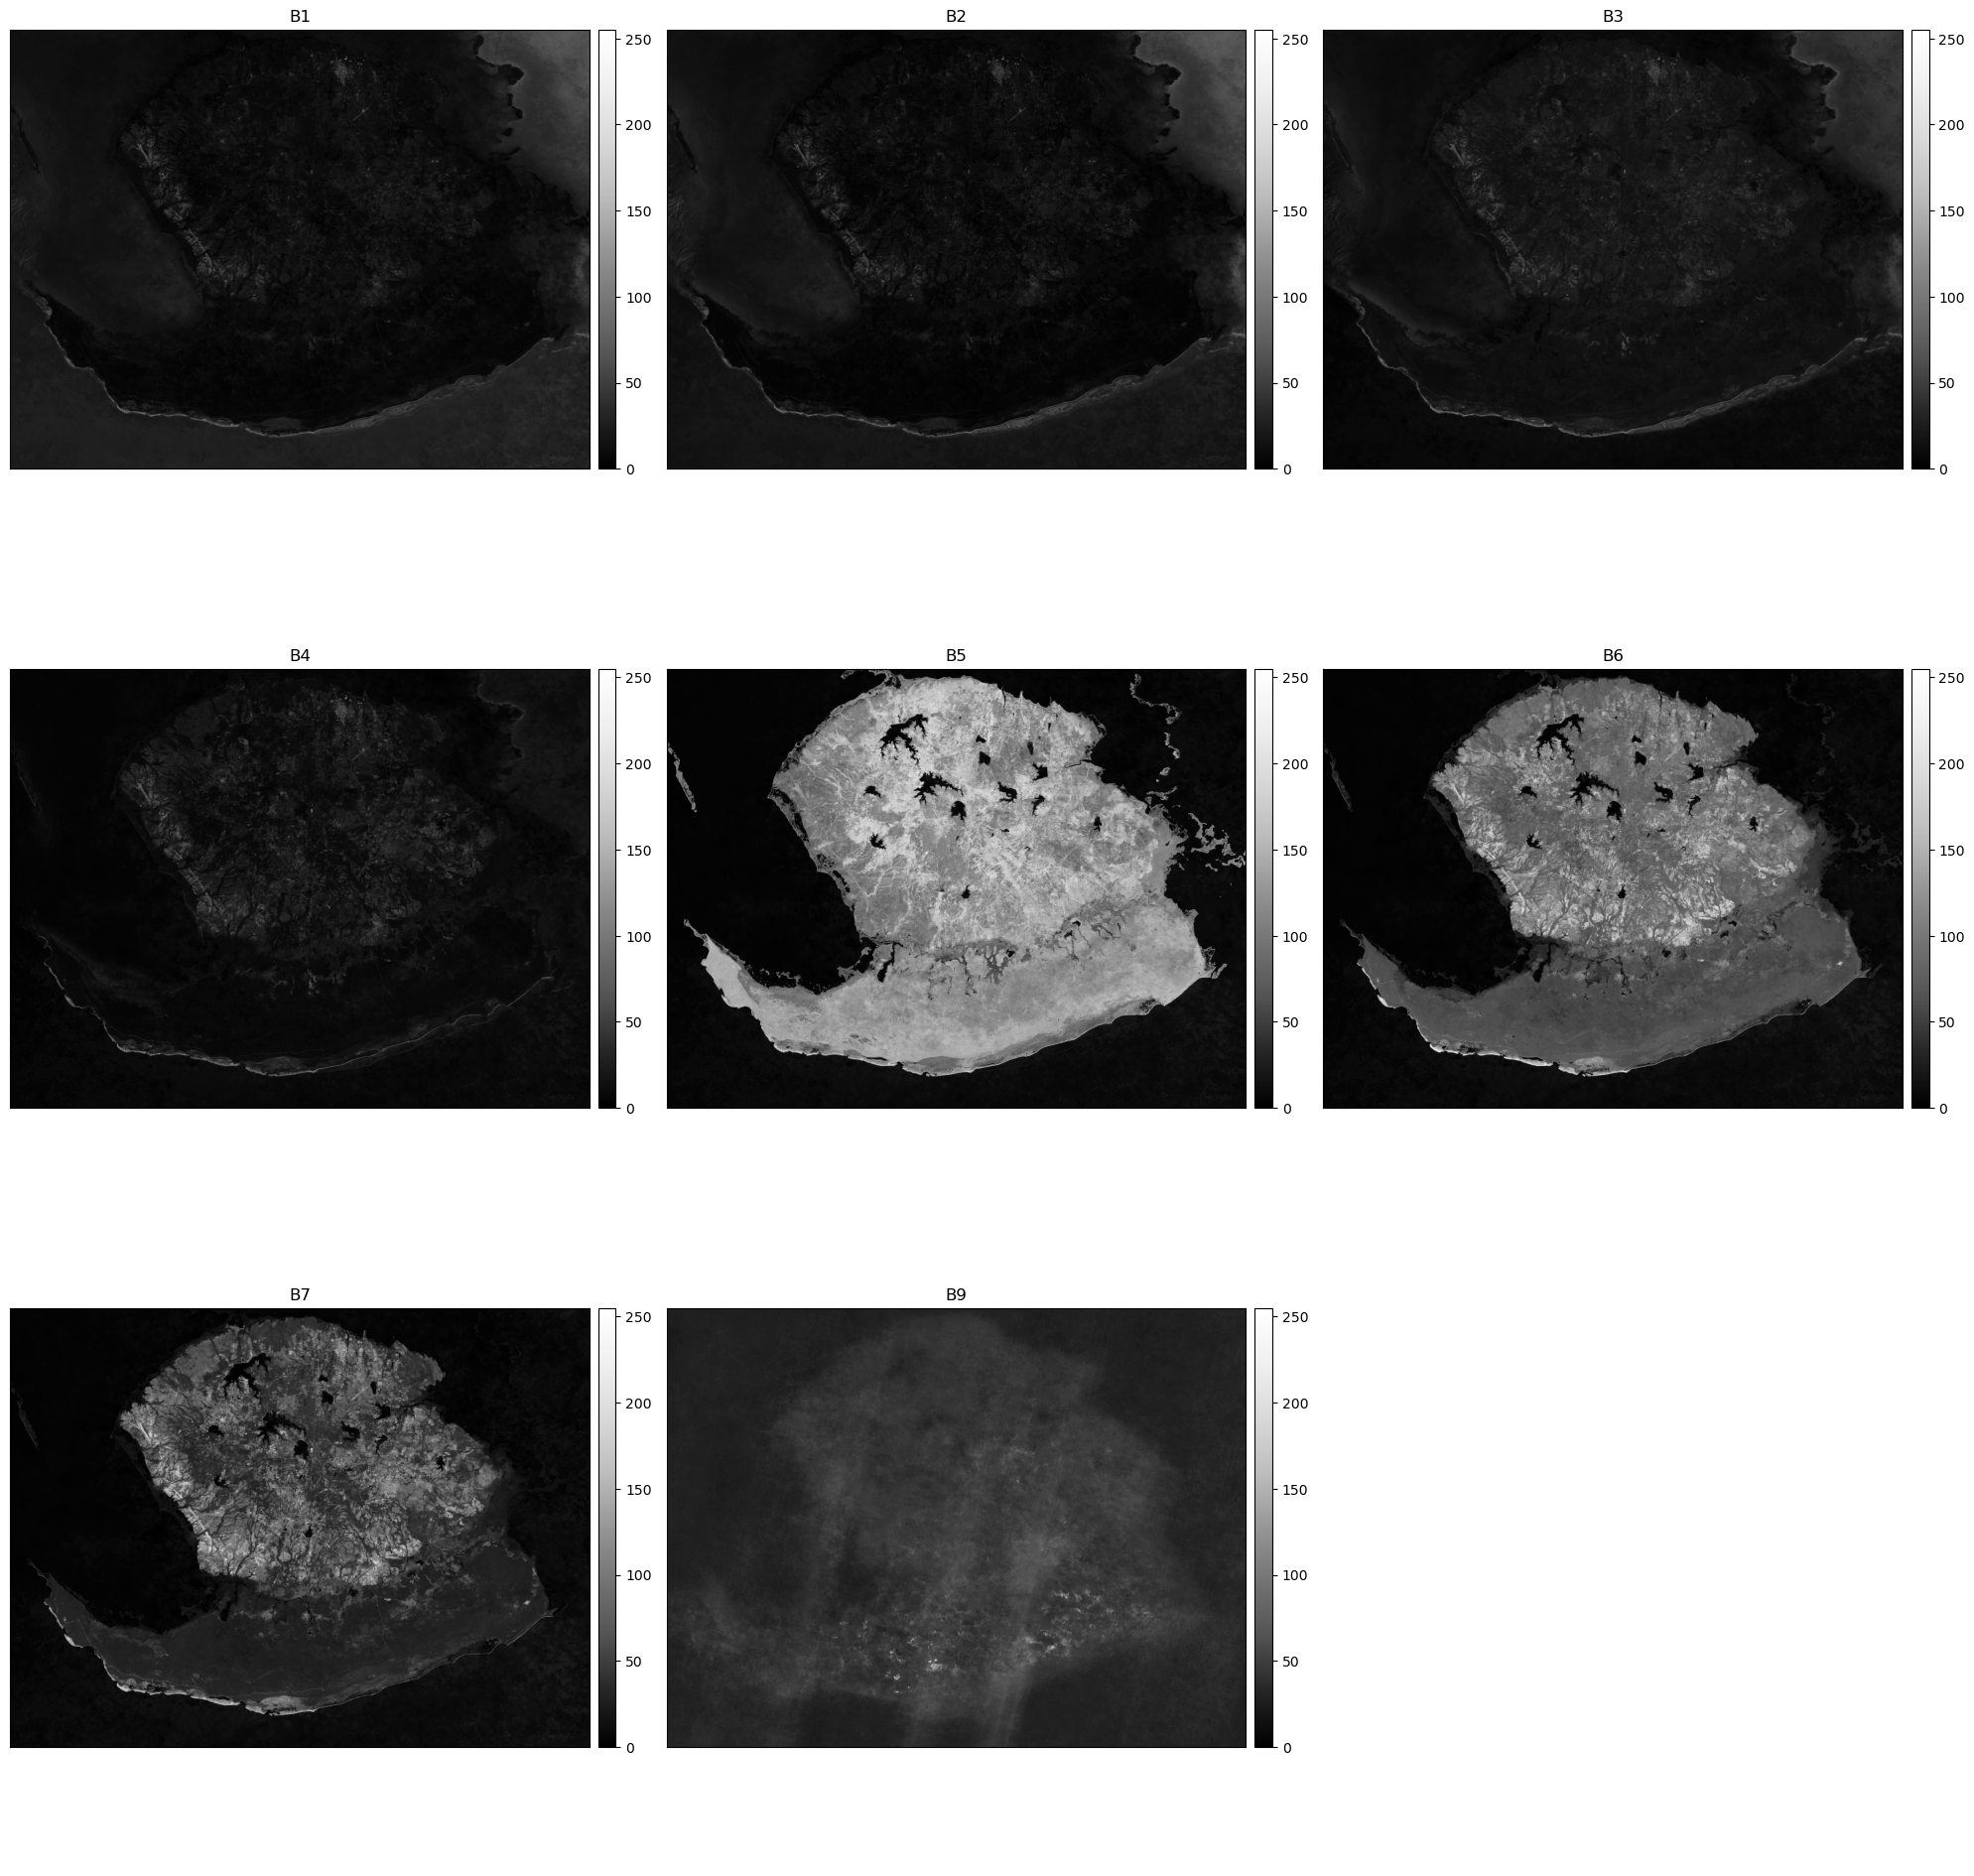

array([[<Axes: title={'center': 'B1'}>, <Axes: title={'center': 'B2'}>,
        <Axes: title={'center': 'B3'}>],
       [<Axes: title={'center': 'B4'}>, <Axes: title={'center': 'B5'}>,
        <Axes: title={'center': 'B6'}>],
       [<Axes: title={'center': 'B7'}>, <Axes: title={'center': 'B9'}>,
        <Axes: >]], dtype=object)

In [14]:
# plot median_image_raster using earthpy
ep.plot_bands(median_image_raster.read(), 
              title=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"],
              cbar=True, scale=True, figsize=(20, 20))


### 3.3 Ground Truth Data (Sampling)

Ground truth data is required for model training and testing. Utilizing ArcGIS Pro with ESRI's World Imagery data (ESRI, 2024) and the Landsat 8 composite image, six distinct land cover types for Cuba were identified: Urban, Agriculture, Forest (including heavy vegetation), Barren (including lighter vegetation), Shallow Water, and Deep Ocean. While "land cover" typically refers to terrestrial surfaces, inclusion of deep ocean and shallow water allows comprehensive study of water bodies, critical for Cuba given its extensive coastline and vulnerability to climate change. Ground truth data, manually collected as polygon samples of each class, was exported as a geojson file. Using the code below, these polygons are used to randomly sample Cuba's Landsat raster image. With 10,000 samples per land cover type chosen for optimal balance between data completeness and computational efficiency, we obtain a dataset comprising land cover types and their corresponding pixel values across the selected bands.

In [15]:
# Check if samples file exists
samples_path = os.path.join(temp_dir, "cuba_samples.csv")
if not os.path.exists(samples_path):
    print("Unable to find Cuba samples file. Creating a new one, this may take a while...")

    # Load cuba_samples_polygons.geojson as an Earth Engine FeatureCollection
    cuba_samples = geemap.geojson_to_ee(os.path.join('data', 'cuba_samples_polygons.geojson'))

    # Create an empty list to store the results
    result_list = []

    # Iterate through each 'type' in cuba_samples
    types = cuba_samples.aggregate_array("type").distinct().getInfo()

    for type_value in types:
        print("Sampling: ", type_value)
        # Filter cuba_samples by the current type
        samples_filtered = cuba_samples.filter(ee.Filter.eq("type", type_value))
        
        # Sample the median image at the locations of the filtered samples
        sampled_image = median_image.addBands(ee.Image.constant(CLASS_VALUES[type_value]).rename('int_type')).sample(
            region=samples_filtered.geometry(),
            scale=30,
            numPixels=NUM_SAMPLES_PER_CLASS,  # Specify the number of pixels to sample
            geometries=True,
            seed=SEED
        )
        
        # Add the sampled image to the result list
        result_list.append(sampled_image)

    # Merge all the results into a single ImageCollection
    extract = ee.FeatureCollection(result_list).flatten()

    # -----------------------------------------------------------

    print("Extracting data...")
    # Convert extract to a pandas DataFrame
    samples = geemap.ee_to_df(extract)
    
    # Add column 'int_type' that gives an integer value to each class
    samples['type'] = samples['int_type'].map(class_labels)

    samples = samples.sample(frac = 1, random_state=SEED) # Shuffle data

    # Save the samples to a CSV file in the temporary directory
    samples.to_csv(os.path.join(temp_dir, "cuba_samples.csv"), index=False)

    print("Cuba samples file created successfully.")

else:
    print("Found existing Cuba samples file. Using that instead.")
    samples = pd.read_csv(samples_path)

samples.head()

Found existing Cuba samples file. Using that instead.


B1        B2        B3        B4        B5        B6        B7  \
0  0.146778  0.129685  0.124542  0.109618  0.338564  0.267969  0.143241   
1  0.104663  0.080174  0.064804  0.042566  0.236013  0.097950  0.038907   
2  0.105999  0.082121  0.062945  0.040541  0.267835  0.117459  0.045047   
3  0.120281  0.097365  0.083267  0.053222  0.378010  0.165814  0.062410   
4  0.157431  0.137587  0.120909  0.115785  0.204957  0.264614  0.177775   

         B9  int_type    type  
0  0.000971         0   urban  
1  0.001069         5  forest  
2  0.001414         5  forest  
3  0.000693         4  barren  
4  0.000949         4  barren

We can use a pairplot to visualize the relationship between the different bands and their land cover types. Some patterns emerge, such as the tendency for the water land cover types (deep ocean and shallow waters) to have lower values in bands 4 through 7, which is caused by the absorption of light in the water. We can also begin to see separation and grouping patterns between points of like land cover types, particularly in bands 2 through 5. This is a good sign that a machine learning model will be able to classify the land cover types.

It is important to note that this plot only shows the direct relationship between any 2 bands. This allows us to get a better understanding of the data, but further reinforces the need for a more complex model to sort through the dense mix of data.


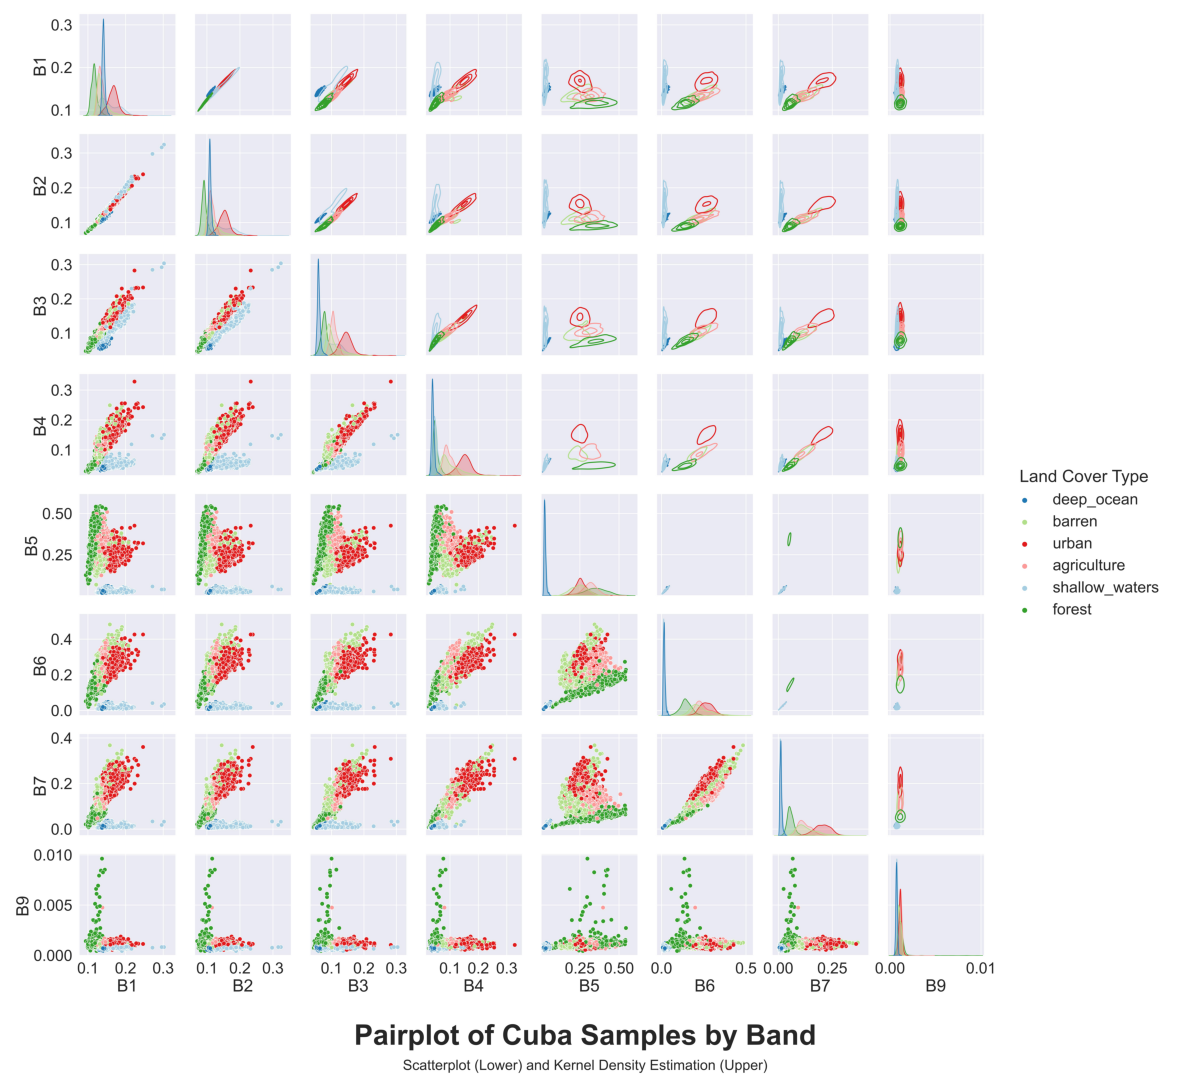

In [49]:
# Get the pairplot image (to save on loading time)
path_file = os.path.join(temp_dir, "pairplot.jpg")

if os.path.exists(path_file):
    # Load the JPEG image
    plt.figure(figsize=(15, 15))
    img = plt.imread(path_file)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

else:
    snspalette = {name: PALETTE[i] for i, name in enumerate(class_labels.values())}

    # Use the color palette in the pairplot
    sns.set_theme(font_scale=2)  # Increase the font size of the legend
    g = sns.pairplot(samples.drop(columns=['int_type']).sample(frac=0.1, random_state=SEED), 
                    hue="type", palette=snspalette, corner=False, plot_kws={'alpha': 0})
    g.map_upper(sns.kdeplot)
    g.map_lower(sns.scatterplot)  # Scatter plots in the lower triangle
    g._legend.set_title("Land Cover Type")  # Add a title to the legend

    # Add a title to the plot
    g.figure.suptitle("Pairplot of Cuba Samples by Band", y=-0.01, fontsize=40, fontweight='bold', ha='center')

    # Add a subtitle just below the title
    g.figure.text(x=0.5, y=-0.055, s="Scatterplot (Lower) and Kernel Density Estimation (Upper)", fontsize=20, ha='center')

    # Save the pairplot as a JPEG image
    plt.savefig(path_file, bbox_inches='tight', dpi=600)

    plt.show()

# Reset graph style for remaining graphs
plt.style.use('default')

## 4.0 | Methodology

With the data ready, a CART, Random Forest, XGBoost, and a Convoluted Neural Network (CNN) model will be created. Each model will be trained and tested on the same split (75% training, 25% testing) of data to ensure equal comparison. The four models were chosen due to their diverse nature of operation, and to provide a comparison between simple (CART) and more complex (CNN) models. Each model was iteratively designed and constructed so as to optimize its independence performance.

In [17]:
# Split data into training and testing (75% training, 25% testing)
train = samples.sample(frac=0.75, random_state=SEED)
test = samples.drop(train.index)

# Split between features and label
train_features = train[FEATURES]
train_label = train[['int_type']]
test_features = test[FEATURES]
test_label = test[['int_type']]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), num_classes=N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), num_classes=N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}')
print(f'Train label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (44208, 8, 1)
Test features: (14736, 8, 1)
Train label: (44208, 7)
Test label: (14736, 7)


In [18]:
# Create a directory for the models files if it doesn't exist
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

Default models were initially created for CART, Random Forest, and XGBoost to estimate hyperparameter ranges. GridSearchCV was utilized to determine the best parameters for each model, which were then used to create the final models.

We then calculate the classification accuracy for the training and testing data for each model for later comparison, as well as the permutation importances of the features to get a sense of which bands are most important for the classification.

### 4.1 CART Model

In [19]:
# Modify train and test features to be 2D arrays (for CART and Random Forest)
train_x = train_input.reshape(train_input.shape[0], train_input.shape[1])
train_y = train_output.reshape(train_output.shape[0], train_output.shape[1])

test_x = test_input.reshape(test_input.shape[0], test_input.shape[1])
test_y = test_output.reshape(test_output.shape[0], test_output.shape[1])

In [20]:
# a CART using default settings
cart_default = DecisionTreeClassifier(random_state=SEED)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 34


In [21]:
'''
Due to the significant amount of time required to train the models, 
the models were saved to the 'models' folder through pickle and keras files and are loaded in when the code below is run. 
If you wish to re-train the models, you can delete the files in the models folder and rerun the code.
'''

output_path = os.path.join(models_dir, "dt_final.pkl")
if not os.path.exists(output_path):
    
    print("CART model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

    dt = DecisionTreeClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    clf = GridSearchCV(dt, hyperparameters)

    clf.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print("The best parameter value is: ")
    print(clf.best_params_)
    print("The best score is: ")
    print(clf.best_score_)

    print("Creating and training CART model with best parameters...")

    dt_final = DecisionTreeClassifier(max_depth=clf.best_params_['max_depth'], 
                                      min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
    dt_final.fit(train_x, train_y)

    print("CART model trained successfully. Saving it in models folder...")

    # Save CART model
    with open(output_path, 'wb') as f:
        pickle.dump(dt_final, f)

    print("CART model saved successfully.")

else:
    print("Found existing CART model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        dt_final = pickle.load(f)
    
    print("CART model loaded successfully.")

Found existing CART model. Loading it in..
CART model loaded successfully.


In [22]:
# Print the max depth and number of estimators for the dt_final model
print("Max depth: ", dt_final.get_params()['max_depth'])
print("Min samples split : ", dt_final.get_params()['min_samples_split'])

Max depth:  20
Min samples split :  2


In [23]:
print("Classification accuracy on the training data:")
print(dt_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(dt_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
0.9909971045964532
Classification accuracy on the testing data:
0.9140200868621065


In [24]:
# some attributes of the tree
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))

Tree depth:20
Number of leaves:1934


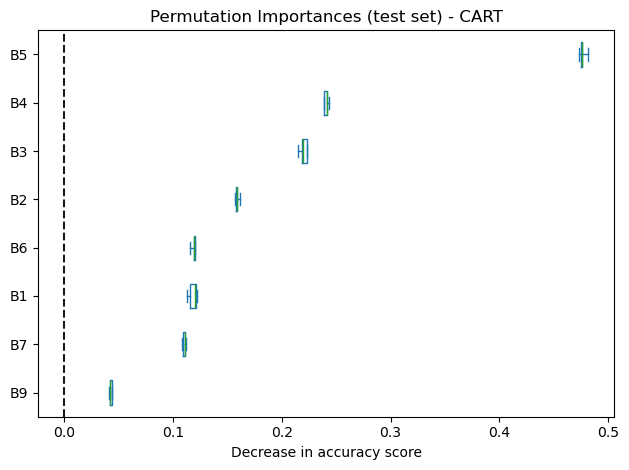

In [25]:
result = permutation_importance(
    dt_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - CART")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### 4.2 Random Forest Model

In [26]:
output_path = os.path.join(models_dir, "rf_final.pkl")
if not os.path.exists(output_path):
    
    print("Random Forest model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

    rf = RandomForestClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    clf = GridSearchCV(rf, hyperparameters)

    clf.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print ("The best parameter value is: ")
    print (clf.best_params_)
    print ("The best score is: ")
    print (clf.best_score_)

    print("Creating and training Random Forest model with best parameters...")

    rf_final = RandomForestClassifier(max_depth=clf.best_params_['max_depth'], 
                                      min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
    rf_final.fit(train_x, train_y)

    print("Random Forest model trained successfully. Saving it in models folder...")

    # Save RF model
    with open(output_path, 'wb') as f:
        pickle.dump(rf_final, f)

    print("Random Forest model saved successfully.")

else:
    print("Found existing Random Forest model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        rf_final = pickle.load(f)
    
    print("Random Forest model loaded successfully.")

Found existing Random Forest model. Loading it in..
Random Forest model loaded successfully.


In [27]:
# Print the max depth and number of estimators for the rf_final model
print("Max depth: ", rf_final.get_params()['max_depth'])
print("Number of estimators: ", rf_final.get_params()['n_estimators'])

Max depth:  20
Number of estimators:  100


In [28]:
print("Classification accuracy on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
0.9925805284111473
Classification accuracy on the testing data:
0.933699782844734


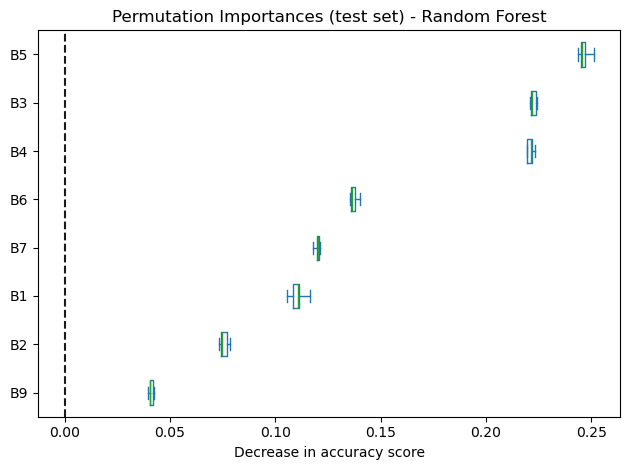

In [29]:
result = permutation_importance(
    rf_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - Random Forest")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### 4.3 XGBoost Model

In [30]:
output_path = os.path.join(models_dir, "xgb_final.pkl")
if not os.path.exists(output_path):
    
    print("XGBoost model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[50,100,150,200,250]}

    xgb = XGBClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    gscv_xgb = GridSearchCV(xgb, hyperparameters)

    gscv_xgb.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print ("The best parameter value is: ")
    print (gscv_xgb.best_params_)
    print ("The best score is: ")
    print (gscv_xgb.best_score_)

    print("Creating and training XGBoost model with best parameters...")

    xgb_final = XGBClassifier(max_depth=gscv_xgb.best_params_['max_depth'], 
                              n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=SEED)
    xgb_final.fit(train_x, train_y)

    print("XGBoost model trained successfully. Saving it in models folder...")

    # Save XGB model
    with open(output_path, 'wb') as f:
        pickle.dump(xgb_final, f)

    print("XGBoost model saved successfully.")

else:
    print("Found existing XGBoost model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        xgb_final = pickle.load(f)
    
    print("XGBoost model loaded successfully.")

Found existing XGBoost model. Loading it in..
XGBoost model loaded successfully.


In [31]:
# Print the max depth and number of estimators for the xgb_final model
print("Max depth: ", xgb_final.get_params()['max_depth'])
print("Number of estimators: ", xgb_final.get_params()['n_estimators'])

Max depth:  30
Number of estimators:  150


In [32]:
print("Classification accuracy on the training data:")
print(xgb_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(xgb_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
1.0
Classification accuracy on the testing data:
0.9368892508143323


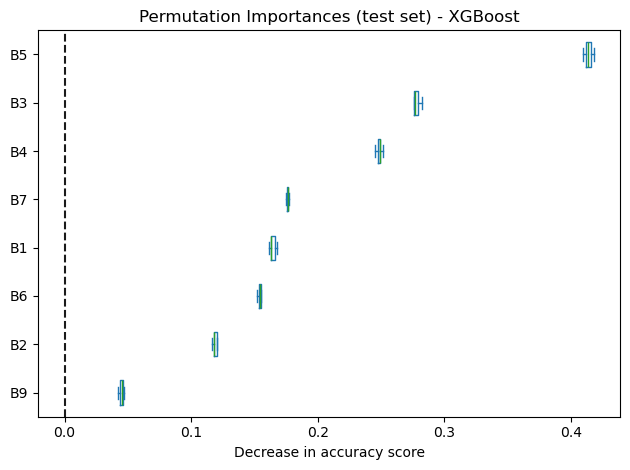

In [33]:
result = permutation_importance(
    xgb_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - XGBoost")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### 4.4 Neural Network Model

#### 4.4.1 Make Model

In [34]:
output_path = os.path.join(models_dir, "nn_final.keras")
if not os.path.exists(output_path):
    
    print("Neural Network model not found. Making a new one...")

    # Make model for our data
    # Input shape
    train_shape = train_input.shape
    input_shape = (train_shape[1], train_shape[2])

    # Model parameter
    neuron = 64
    drop = 0.2
    kernel = 5

    # Make sequential model
    nn_model = Sequential([
        Input(input_shape),
        Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
        Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
        Dropout(drop),
        Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
        Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
        Dropout(drop),
        GlobalMaxPooling1D(),
        Dense(neuron * 4, activation='relu'),
        Dropout(drop),
        Dense(neuron * 2, activation='relu'),
        Dropout(drop),
        Dense(N_CLASSES + 1, activation='softmax')
    ])

    need_to_train_nn = True
    nn_model.summary()


else:
    print("Found existing Neural Network model. Loading it in..")
    # load
    nn_model = keras.models.load_model(output_path)
    need_to_train_nn = False
    print("Neural Network model loaded successfully.")


Found existing Neural Network model. Loading it in..
Neural Network model loaded successfully.


The neural networks model layout can be seen in the diagram below.
 
This model, based on (Habibie et al., 2024), underwent iterative modifications to enhance performance for this specific dataset. It employs a sequential neural network architecture built with Keras, incorporating 2 sets of Conv1D layers. ReLU activation and 'same' padding maintain spatial information in Conv1D layers, while dropout layers curb overfitting. Two dense layers follow for feature processing and dimensionality reduction. The output layer, a Dense layer with softmax activation, produces probabilities for the 6 land cover classes. Training utilizes the Adam optimizer with categorical cross-entropy loss, with early stopping to prevent overfitting and enhance training efficiency.

<img src="images/nn_model_plot.png" width="200">

In [33]:
'''
The neural network diagram was created using this code, 
though the code is now not ran as it requires various other packages and setup to run properly.
'''

# plot_model(nn_model, to_file=os.path.join(temp_dir, "nn_model_plot.png"), show_shapes=True, 
#           show_layer_names=False, rankdir='TB', show_trainable=True)

#### 4.4.2 Train Model

In [35]:
if need_to_train_nn:
    print("Training Neural Network model...")
    
    # Compile the model
    nn_model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',  # Updated the loss parameter
        metrics=['accuracy']
    )

    # Create callback to stop training if loss not decreasing
    stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
    )

    # Fit the model
    result = nn_model.fit(
        x=train_input, y=train_output,
        validation_data=(test_input, test_output),
        batch_size=1024,
        callbacks=[stop],
        epochs=1000,
    )
    history = pd.DataFrame(result.history)

    # Save the fit results
    with open(os.path.join(models_dir, "nn_fit_history.pkl"), 'wb') as f:
        pickle.dump(history, f)

    # Save the model
    nn_model.save(output_path)
else:
    print("Neural Network model already trained.")
    
    with open(os.path.join(models_dir, "nn_fit_history.pkl"), 'rb') as f:
        history = pickle.load(f)

Neural Network model already trained.


We can see through the training history that the model was able to quickly settle on a high accuracy for both the training and testing data.

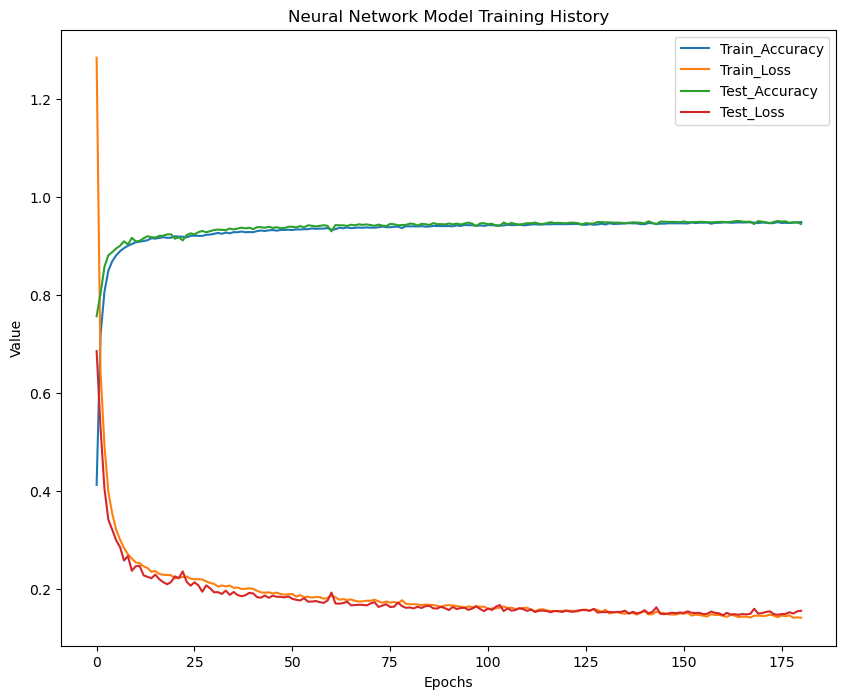

In [36]:
# Show history

plt.figure(figsize = (10, 8))

plt.plot(range(len(history['accuracy'].values.tolist())), 
         history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')

plt.plot(range(len(history['val_accuracy'].values.tolist())), 
         history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')

plt.xlabel('Epochs')
plt.ylabel('Value')

# Add title
plt.title('Neural Network Model Training History')


plt.legend()
plt.show()

In [37]:
# Print the R2 score
nn_model_train_score = nn_model.evaluate(train_input, train_output)
nn_model_test_score = nn_model.evaluate(test_input, test_output)

print("Classification accuracy on the training data:")
print(nn_model_train_score[1])
print("Classification accuracy on the testing data:")
print(nn_model_test_score[1])

1382/1382 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9533 - loss: 0.1298
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9499 - loss: 0.1421
Classification accuracy on the training data:
0.9533116221427917
Classification accuracy on the testing data:
0.9486970901489258


## 5.0 | Results
### 5.1 Run Models on Isla de La Juventud

To finalize our results we begin by running our various models on our subset of Cuba (Isla de la Juventud). This will allow us to visualize the results and see if any immediate issues arise.

In [38]:
src_array = median_image_raster.read()
bands = median_image_raster.count

In [39]:
row_per_pixel = src_array.reshape([bands,-1]).T
columns = [f'band_{n}' for n in range(1,bands+1)]
row_per_pixel_df  = pd.DataFrame(row_per_pixel,columns=columns)

In [40]:
# Check if model predictions pickle file exists
output_path = os.path.join(temp_dir, "model_predictions.pkl")
if not os.path.exists(output_path):
    print("Model predictions file not found. Creating a new one...")

    # CART PREDICTION ---------------------------------------------------
    print("Predicting land cover using CART model...")

    dt_prediction = dt_final.predict(row_per_pixel_df).astype('float64')
    dt_prediction = np.argmax(dt_prediction, 1)
    dt_prediction = dt_prediction.reshape(shape[0], shape[1])

    # RANDOM FOREST PREDICTION --------------------------------------------
    print("Predicting land cover using Random Forest model...")

    rf_prediction = rf_final.predict(row_per_pixel_df).astype('float64')
    rf_prediction = np.argmax(rf_prediction, 1)
    rf_prediction = rf_prediction.reshape(shape[0], shape[1])

    # XGBOOST PREDICTION ---------------------------------------------------
    print("Predicting land cover using XGBoost model...")

    xgb_prediction = xgb_final.predict(row_per_pixel_df).astype('float64')
    xgb_prediction = np.argmax(xgb_prediction, 1)
    xgb_prediction = xgb_prediction.reshape(shape[0], shape[1])

    # NEURAL NETWORK PREDICTION ---------------------------------------------------
    print("Predicting land cover using Neural Network model...")

    # NN Prediction requires slightly different steps due to the model's input shape
    image_input = []
    for x in range(8):
        image_input.append(median_image_raster.read(x + 1))
    image_input = reshape_input(np.stack(image_input).reshape(8, -1).T)

    # Predict
    nn_prediction = nn_model.predict(image_input, batch_size=4096*20)
    nn_prediction = np.argmax(nn_prediction, 1)
    nn_prediction = nn_prediction.reshape(shape[0], shape[1])

    print("Saving results...")
    # Save model predictions
    with open(output_path, 'wb') as f:
        pickle.dump({
            'dt_prediction': dt_prediction,
            'rf_prediction': rf_prediction,
            'xgb_prediction': xgb_prediction,
            'nn_prediction': nn_prediction
        }, f)

    model_predictions = {"Decision Tree": dt_prediction, "Random Forest": rf_prediction, 
                         "XGBoost": xgb_prediction, "Neural Network": nn_prediction}

    print("Model predictions file created successfully.")

else:
    print("Found existing model predictions file. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        model_predictions = pickle.load(f)
    
    dt_prediction = model_predictions['dt_prediction']
    rf_prediction = model_predictions['rf_prediction']
    xgb_prediction = model_predictions['xgb_prediction']
    nn_prediction = model_predictions['nn_prediction']

    
    print("Model predictions loaded successfully.")

Found existing model predictions file. Loading it in..
Model predictions loaded successfully.


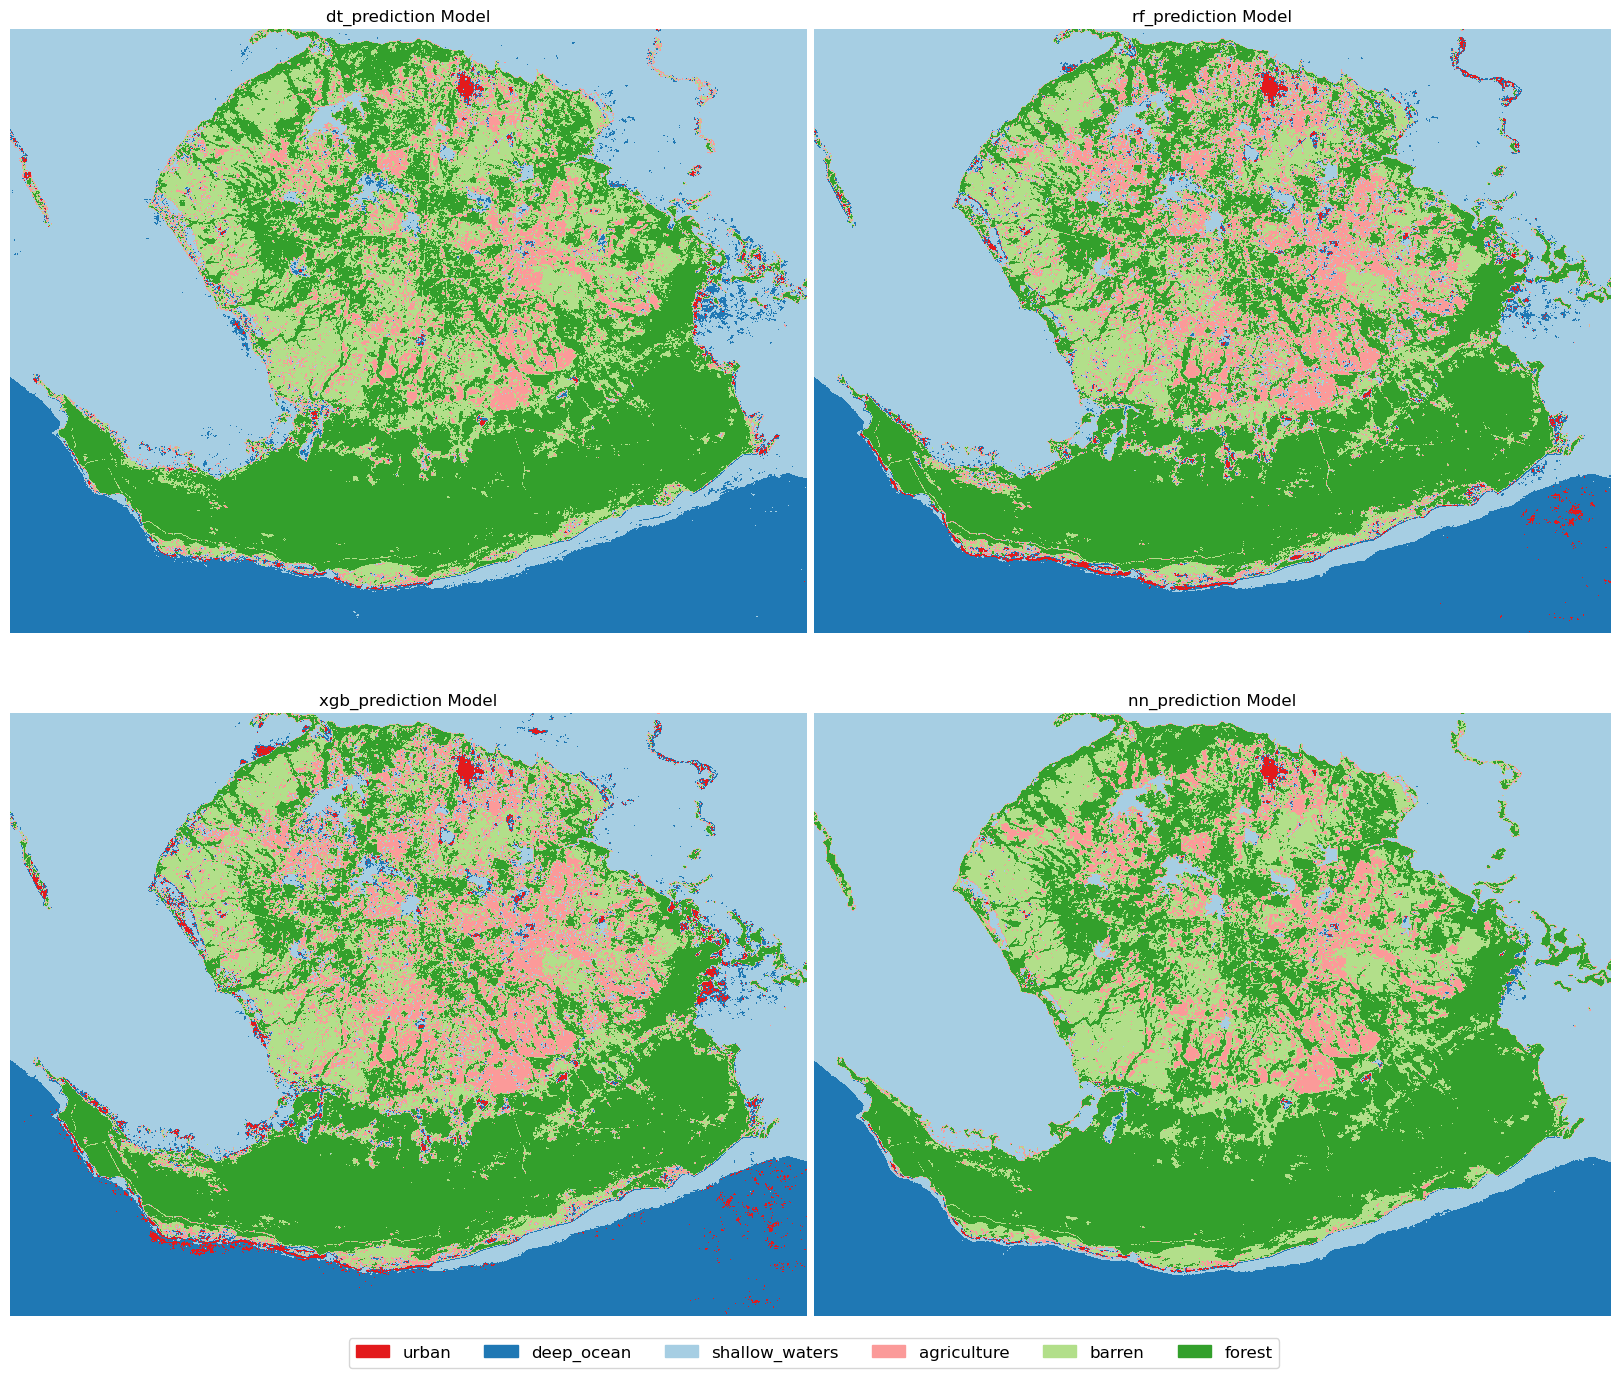

In [41]:
# Create a custom colormap with class labels
colors = [PALETTE[i] for i in CLASSES]
cmap = ListedColormap(colors)

# Plotting the results of each model in separate subplots
num_models = 4
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(model_predictions.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Plot the results of the current model
    ax.imshow(value, cmap=cmap)
    
    # Add title for the subplot
    ax.set_title(f"{key} Model")
    
    # Remove axis
    ax.axis('off')

# Create a custom legend
legend_handles = [mpatches.Patch(color=PALETTE[i], label=class_labels[i]) for i in CLASSES]
plt.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0, -0.1), ncol=len(CLASSES), fontsize='12')

plt.subplots_adjust(hspace=0.01, wspace=0.01, bottom=0.15, top=1, left=0, right=1)

plt.show()

While training, all models demonstrated high accuracy scores, indicating overall strong performance. However, the maps indicate overprediction in the urban class by the XGBoost and Random Forest models.
 
To gain a deeper quantitative insight into model performance, we calculate train/test accuracy differences, followed by analyzing confusion matrices and classification reports. It's important to note that although the maps depict only Isla de la Juventud, the models were trained on the entire island of Cuba, making the results representative of the entire country.


### 5.2 Quantitative Analysis

In [42]:
# create a list of models
list_name_models = ['CART', 'RF', 'XGBoost']
# use the models from above
list_reg_models = [dt_final, rf_final, xgb_final]

dict_models = dict()

for name, model in zip(list_name_models, list_reg_models):
    dict_models[name] = [model.score(train_x, train_y), model.score(test_x, test_y), 
                         model.score(train_x, train_y) - model.score(test_x, test_y)]

# add the neural network model
dict_models['Neural Network'] = [nn_model_train_score[1], nn_model_test_score[1], 
                                 nn_model_train_score[1] - nn_model_test_score[1]]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['Train Accuracy', 'Test Accuracy', 'Acc. Diff'])
df_models = df_models.sort_values(by='Acc. Diff', ascending=True)

df_models

Train Accuracy  Test Accuracy  Acc. Diff
Neural Network        0.953312       0.948697   0.004615
RF                    0.992581       0.933700   0.058881
XGBoost               1.000000       0.936889   0.063111
CART                  0.990997       0.914020   0.076977

With accuracies above 0.9, each model outperforms the previously discussed global models. Despite its lower training accuracy, the neural network exhibits superior overall performance (highest test accuracy and lowest accuracy difference), likely attributed to its complexity, better capturing band interactions. These results signify the model's ability to identify new information without overfitting or underfitting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


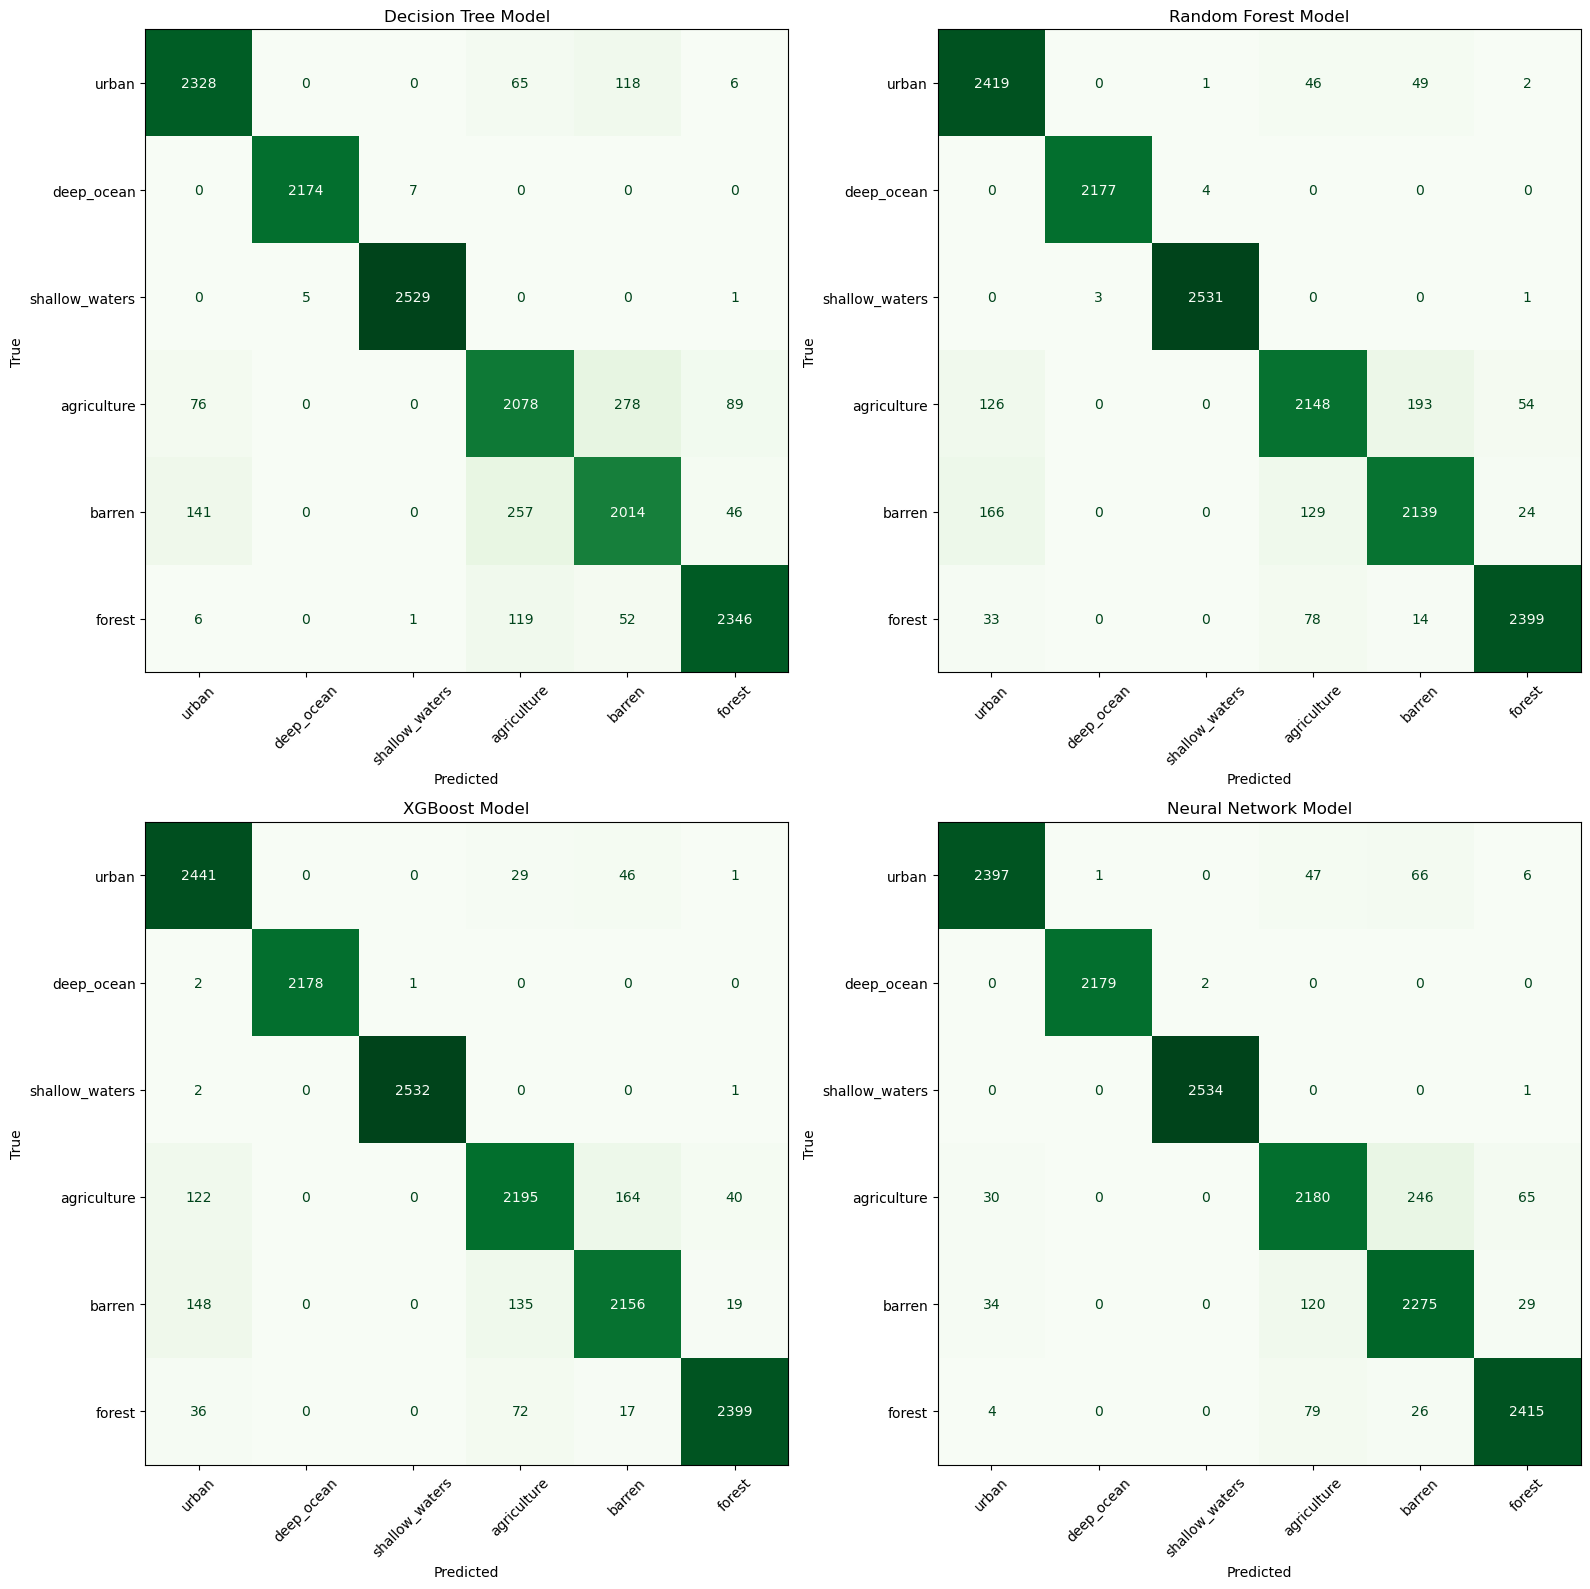

In [43]:
# Plot the confusion matrix for all models
models = {"Decision Tree": dt_final, "Random Forest": rf_final, "XGBoost": xgb_final, "Neural Network": nn_model}

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(models.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Make predictions
    if key == "Neural Network":
        y_pred = value.predict(test_input, batch_size=4096*20)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_output, 1)
    else:
        y_pred = value.predict(test_x)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_y, 1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(N_CLASSES))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels.values())
    disp.plot(cmap='Greens', ax=ax)
    ax.set_title(f"{key} Model")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Hide colorbar
    disp.im_.colorbar.remove()

    # Tilt x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [44]:
'''
Functions for plotting classification report
Source: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
'''

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, 
            correct_orientation=False, cmap='RdBu', vmin=None, vmax=None):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=vmin, vmax=vmax)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    for y in range(AUC.shape[0]):
        for x in range(AUC.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.2f' % AUC[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', 
                               vmin=None, vmax=None):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0}'.format(class_names[idx]) for idx, sup  in enumerate(support)]
    figure_width = 12
    figure_height = len(class_names) + 4
    correct_orientation = False
        
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, 
            correct_orientation, cmap=cmap, vmin=vmin, vmax=vmax)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


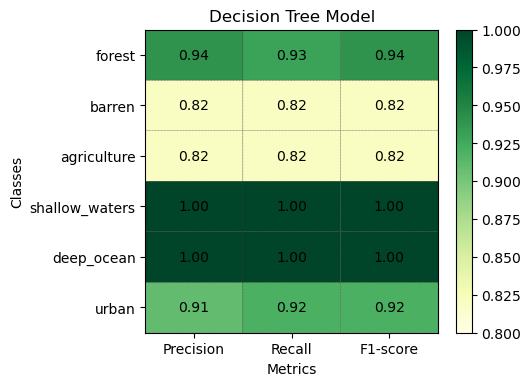

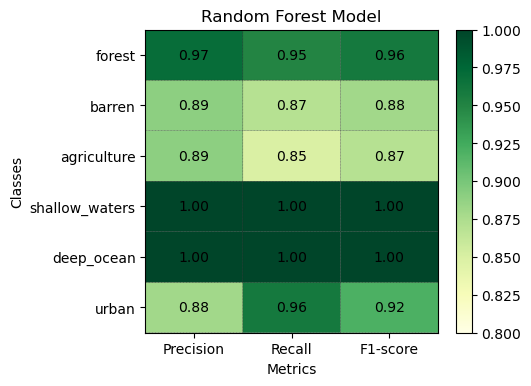

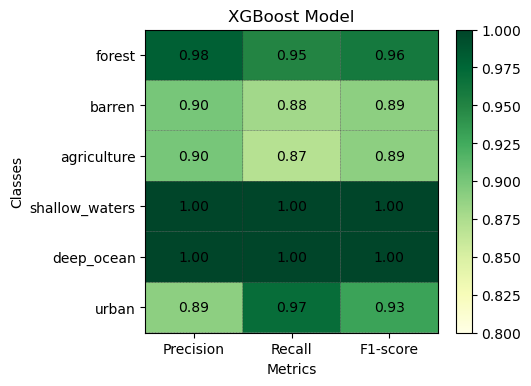

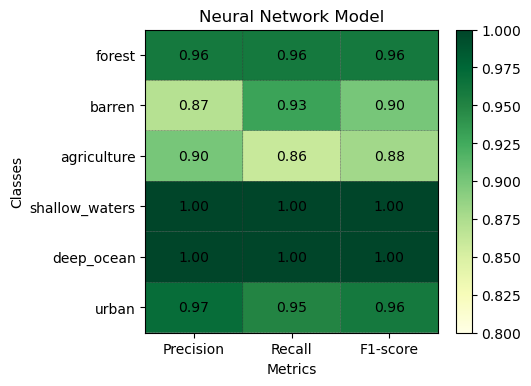

In [45]:
# Plot the classification report for all models
models = {"Decision Tree": dt_final, "Random Forest": rf_final, "XGBoost": xgb_final, "Neural Network": nn_model}

for i, (key, value) in enumerate(models.items()):
    
    # Make predictions
    if key == "Neural Network":
        y_pred = value.predict(test_input, batch_size=4096*20)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_output, 1)
    else:
        y_pred = value.predict(test_x)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_y, 1)

    # Plot the classification report
    class_report = classification_report(y_true, y_pred, target_names=class_labels.values())
    
    # Plot the classification report
    plot_classification_report(class_report, title=f"{key} Model", cmap='YlGn', vmin=0.8, vmax=1.0)


From the results displayed in the confusion matrix and classification reports, all models excelled in categorizing water types (deep ocean and shallow water), as anticipated from their distinct spectral characteristics observed earlier. Forest classification was also successful across all models. However, distinguishing between barren land and agriculture proved challenging, as indicated by the confusion matrix, which is understandable given their similarities. Urban classification, arguably the most important, was generally accurate across models, with the neural network achieving the highest precision and F1-score. Yet, both XGBoost and Random Forest models tended to overpredict urban areas, reflected in their lower urban precision, as expected from our visual inspection of the prediction maps. The neural network model stood out for its overall performance, although permutation importance couldn't be calculated for it due to its black box nature. For the other models, bands 3, 4, and 5 emerged as the most influential, aligning with previous observations of strong grouping patterns of these bands in the pairplot. This makes sense, as these bands are commonly used for understanding vegetation density such as through the use of the Normalized Difference Vegetation Index (NDVI) which uses bands 5 and 4, or for plotting color infrared which uses all 3 bands (USGS, no date b). Conversely, band 9, primarily capturing cirrus clouds (USGS, no date a), had minimal importance since cloud masking was already applied to the dataset. Ultimately, the neural network model was selected as the best performer due to its consistently high accuracy and metrics (precision, recall and F1-score) across all classes.


### 5.3 Run Neural Network Model on Yearly Data

With our model created and chosen, it can now be used to determine if there has been a change in Cuba's land cover over the past 10 years. We go back to our subset of the Isla de la Juventud, and can use the code below to determine the land cover distribution from 2013 to 2023.

In [46]:
# What percentage of the pixels in the image are classified as each class within the neural network model?
unique, counts = np.unique(nn_prediction, return_counts=True)
prediction_counts = dict(zip(unique, counts))

# Calculate the percentage of each class
total_pixels = np.prod(shape)
percentage_counts = {class_labels[key]: value / total_pixels * 100 for key, value in prediction_counts.items()}
percentage_counts

{'urban': 0.8349901423330643,
 'deep_ocean': 16.07881142324746,
 'shallow_waters': 34.08603130404796,
 'agriculture': 9.070603885138329,
 'barren': 12.64951929221422,
 'forest': 27.280043953018975}

In [47]:
'''
Using a variation of the code used above, we can now loop through the years 2013 to 2023 
and determine the land cover distribution for each year.
'''

years_to_test = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
yearly_results = {year: {} for year in years_to_test}

yearly_results[2023] = percentage_counts

In [48]:
output_path = os.path.join(temp_dir, "yearly_results.pkl")
if not os.path.exists(output_path):
    for year in years_to_test:
        print(f"Processing year {year}...")
        print("Downloading median image...")

        # Filter the Landsat images
        landsat_cuba = image_collection.filterBounds(geometry_cuba).map(mask_clouds)

        # Define start and end dates
        start_date = ee.Date(f'{year}-01-01')
        end_date = ee.Date(f'{year}-12-31')

        # Filter by date
        landsat_cuba = landsat_cuba.filterDate(start_date, end_date)

        # Get median image, only for the geometry of Isla de la Juventud
        # We will use this image for visually displaying the model results
        median_idlj = landsat_cuba.median().clip(geometry_idlj).select(FEATURES)

        print("Converting median image to raster...")

        # Split geometry into smaller subregions (to bypass Earth Engine export limit)
        subgeometries = split_geometry(geometry_idlj, num_parts=3)

        output_path = os.path.join(temp_dir, f"ildj_median_{year}_merged.tif")

        # Export and download each subregion
        for i, subgeometry in enumerate(subgeometries):
            output_filename = os.path.join(temp_dir, f"ildj_median_{year}_part_{i}.tif")
            # Convert Shapely geometry to GeoJSON
            geojson_geometry = json.dumps(mapping(subgeometry))
            task = geemap.ee_export_image(median_idlj, filename=output_filename, region=geojson_geometry, scale=30)
            print(f"Exporting {output_filename}...")

        # Read and merge downloaded images
        output_files = [os.path.join(temp_dir, f"ildj_median_{year}_part_{i}.tif") for i in range(len(subgeometries))]
        datasets = [rasterio.open(file) for file in output_files]
        merged, transform = merge(datasets)

        # Close the datasets
        for dataset in datasets:
            dataset.close()

        # Update the metadata
        profile = datasets[0].profile
        profile.update({"height": merged.shape[1], "width": merged.shape[2], "transform": transform})

        # Output merged image
        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(merged)

        # Delete smaller TIFF files
        for file in output_files:
            os.remove(file)

        print("Predicting landcover using Neural Network model...")

        median_image_raster = rasterio.open(output_path)
        height = median_image_raster.height
        width = median_image_raster.width
        shape = (height, width)

        image_input = []
        for x in range(8):
            image_input.append(median_image_raster.read(x + 1))
        image_input = reshape_input(np.stack(image_input).reshape(8, -1).T)

        # Predict
        nn_prediction = nn_model.predict(image_input, batch_size=4096*20)
        nn_prediction = np.argmax(nn_prediction, 1)
        nn_prediction = nn_prediction.reshape(shape[0], shape[1])

        print("Saving results...")

        # What percentage of the pixels in the image are classified as each class within the neural network model?
        unique, counts = np.unique(nn_prediction, return_counts=True)
        prediction_counts = dict(zip(unique, counts))

        # Calculate the percentage of each class
        total_pixels = np.prod(shape)
        percentage_counts = {class_labels[key]: value / total_pixels * 100 for key, value in prediction_counts.items()}
        
        yearly_results[year] = percentage_counts

        # Close the raster
        median_image_raster.close()

        os.remove(output_path)

    # Save results to pickle file
    output_path = os.path.join(temp_dir, "yearly_results.pkl")
    with open(output_path, 'wb') as f:
        pickle.dump(yearly_results, f)
else:
    print("Found existing yearly results file. Loading it in..")
    with open(output_path, 'rb') as f:
        yearly_results = pickle.load(f)

Found existing yearly results file. Loading it in..


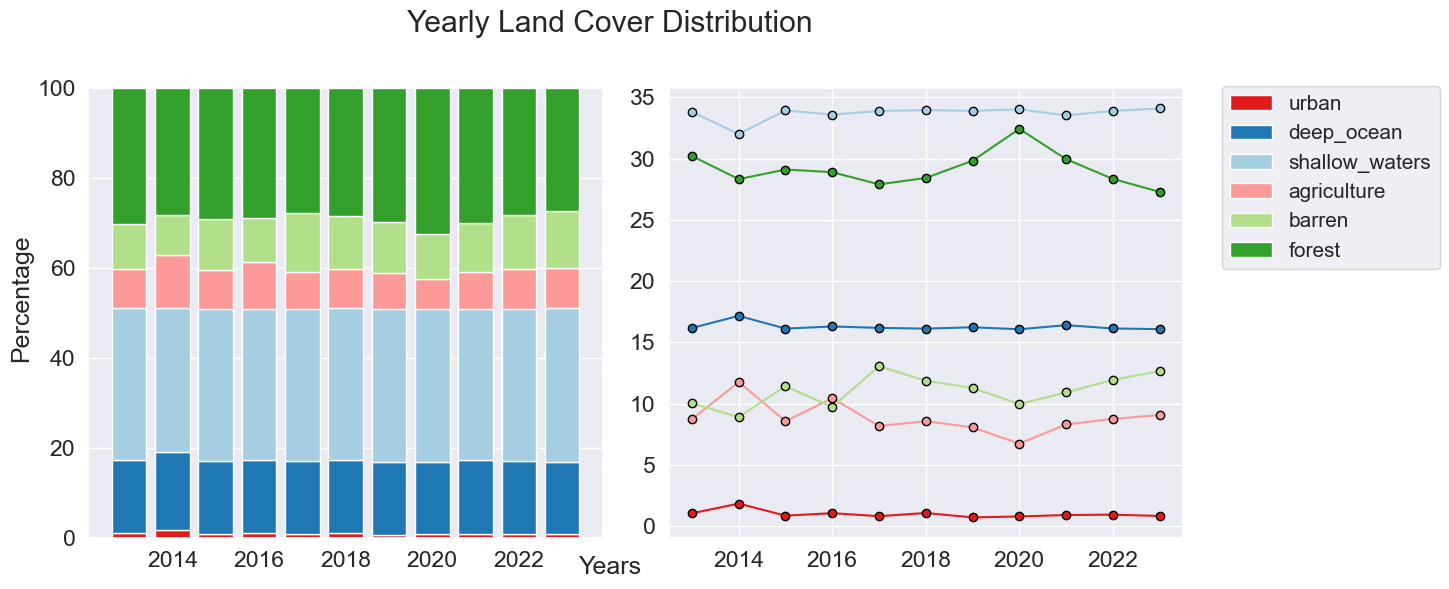

In [49]:
'''
Instead of printing the results, 
we can plot them to better visualize the changes over time.
'''

# Extract the years and land covers from yearly_results
years = list(yearly_results.keys())
land_covers = list(yearly_results[years[0]].keys())

sns.set_theme(font_scale=1.5)

# Prepare the data for the stacked bar chart
data_bar = []
for land_cover in land_covers:
    values = [yearly_results[year][land_cover] for year in years]

    data_bar.append(values)

# Prepare the data for the line graph
data_line = []
for land_cover in land_covers:
    values = [yearly_results[year][land_cover] for year in years]
    data_line.append(values)

colors = PALETTE[:len(land_covers)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Stacked bar chart
cumulative_data = data_bar[0]
ax1.bar(years, data_bar[0], label=land_covers[0], color=colors[0])
for i in range(1, len(land_covers)):
    ax1.bar(years, data_bar[i], bottom=cumulative_data, label=land_covers[i], color=colors[i])
    cumulative_data = [x + y for x, y in zip(cumulative_data, data_bar[i])]

# Line graph
for i in range(len(land_covers)):
    ax2.plot(years, data_line[i], label=land_covers[i], color=colors[i], marker='o', markeredgecolor='black')

# Set common labels and title
fig.suptitle('Yearly Land Cover Distribution')
fig.text(0.5, 0.04, 'Years', ha='center')
fig.text(0, 0.5, 'Percentage', va='center', rotation='vertical')

# Set y axis to be from 0 to 100 for the stacked bar chart
ax1.set_ylim(0, 100)

# Add a common legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.2, 0.87), fontsize='small')

# Show the plot
plt.tight_layout()
plt.show()

Our model shows very little change in any of the land covers over the past 10 years. There is a small yet notable rise in forest cover in 2020, which then subsided over the following years. This coincides with a dip in agricultural and barren land cover. This is probably caused by an increase in overall vegetation cover allowing for the model to categorize more land as forested. Although there are no weather phenomena that may explain this rise, Cuba witnessed a substantial economic decline in 2020, characterized by a 10.9% contraction in its economy and a 10.8% reduction in per capita GDP (Alicia Bárcena et al., 2021). This economic downturn was not a sudden onset, and the timelines do appear to match with the rise of forested cover detected with our model. That being said, correlation does not equal causation and further investigation would need to take place to link the rise of the forested land cover with the economic downturn.

## 6.0 | Conclusion

Through this notebook we cleaned and prepared expansive satellite imagery data, optimized and trained various machine learning models, and extracted meaningful insights into the changing landscapes of Cuba. With a testing accuracy of nearly 95%, our neural network model performed exceptionally well at classifying unmarked land cover in Cuba, far beyond more general global models, creating a powerful tool for understanding Cuba’s past and monitoring on-going changes. With Landsat 8 missions temporal resolution of 16 days and spatial resolution of 30 meters, our model is able to create a constantly updating, high resolution, database of Cuba’s land cover, which can provide significant academic, political, and educational insights. Insights which can lead evidence-based decision-making processes, contributing to sustainable development efforts and environmental conservation initiatives.

## 7.0 | References

Alicia Bárcena, Mario Cimoli, Raúl García-Buchaca, Daniel Titelman, and Sally Shaw. (2021). ESTUDIO ECONOMICO DE AMERICA LATINA Y EL CARIBE 2021: dinamica laboral y politicas de empleo... para una recuperacion sostenible e inclusiva mas a. S.l.: UNITED NATIONS ECONOMIC COMMISSION FOR LATIN AMERICA AND THE CARIBBEAN.

Botella-Rodríguez, E. and González-Esteban, Á. L. (2021). ‘Past and present land reform in Cuba (1959–2020): from peasant collectivisation to re-peasantisation and beyond’. Rural History, 32 (2), pp. 249–264. doi: 10.1017/S0956793321000108.

ESRI. (2024). World Imagery. Available at: https://www.arcgis.com/home/item.html?id=10df2279f9684e4a9f6a7f08febac2a9 (Accessed: 8 April 2024).
Friedl, M. and Sulla-Menashe, D. (2019). ‘MCD12Q1 MODIS/Terra+Aqua Land Cover Type Yearly L3 Global 500m SIN Grid V006’. [object Object]. doi: 10.5067/MODIS/MCD12Q1.006.

Galford, G., Fernandez, M., Roman, J., Monasterolo, I., Ahamed, S., Fiske, G., González-Díaz, P. and Kaufman, L. (2018). ‘Cuban land use and conservation, from rainforests to coral reefs’. Bulletin of Marine Science, 94. doi: 10.5343/bms.2017.1026.

Gebelein, J. (2012). ‘Historical Background of Cuban Land Cover Change’. in Gebelein, J. (ed.) A Geographic Perspective of Cuban Landscapes. Dordrecht: Springer Netherlands (Landscape Series), pp. 1–22. doi: 10.1007/978-94-007-2406-8_1.

González, J. M., Salinas, E., Navarro, E., Artigues, A. A., Remond, R., Yrigoy, I., Echarri, M. and Arias, Y. (2014). ‘The City of Varadero (Cuba) and the Urban Construction of a Tourist Enclave’. Urban Affairs Review. SAGE Publications Inc, 50 (2), pp. 206–243. doi: 10.1177/1078087413485218.

Habibie, M. I., Ramadhan, Nurda, N., Sencaki, D. B., Putra, P. K., Prayogi, H., Agustan, Sutrisno, D. and Bintoro, O. B. (2024). ‘The development land utilization and cover of the Jambi district are examined and forecasted using Google Earth Engine and CNN1D’. Remote Sensing Applications: Society and Environment, 34, p. 101175. doi: 10.1016/j.rsase.2024.101175.

Machado, M. R. (2018). ‘What’s going on with land-use in Cuba?: Disparate data sets and the Cuban agricultural transition’. Journal of Land Use Science. Taylor & Francis, 13 (4), pp. 439–446. doi: 10.1080/1747423X.2018.1533044.

Marine Regions · Cuban 12 NM (Territorial Sea). (no date). Available at: https://www.marineregions.org/gazetteer.php?p=details&id=49126 (Accessed: 12 March 2024).

Marston, C. G., O’Neil, A. W., Morton, R. D., Wood, C. M. and Rowland, C. S. (2023). ‘LCM2021 – the UK Land Cover Map 2021’. Earth System Science Data. Copernicus GmbH, 15 (10), pp. 4631–4649. doi: 10.5194/essd-15-4631-2023.

Nuñez-Penichet, C., Maita-Chamba, J. and Soberón, J. (2023). ‘Land-cover change in Cuba may favor biodiversity: An example using Omphalea (Angiosperma: Euphorbiaceae) and Urania boisduvalii (Lepidoptera: Uraniidae)’. bioRxiv, p. 2023.02.17.529023. doi: 10.1101/2023.02.17.529023.

Sanderson, E. W., Fisher, K., Robinson, N., Sampson, D., Duncan, A. and Royte, L. (2022). ‘The March of the Human Footprint’. EcoEvoRxiv. Available at: https://ecoevorxiv.org/repository/view/3641/ (Accessed: 6 April 2024).

Sanderson, E. W., Jaiteh, M., Levy, M. A., Redford, K. H., Wannebo, A. V. and Woolmer, G. (2002). ‘The Human Footprint and the Last of the Wild: The human footprint is a global map of human influence on the land surface, which suggests that human beings are stewards of nature, whether we like it or not’. BioScience, 52 (10), pp. 891–904. doi: 10.1641/0006-3568(2002)052[0891:THFATL]2.0.CO;2.

USGS. (no date a). How is the Landsat 8 and Landsat 9 Cirrus Band 9 used? | U.S. Geological Survey. Available at: https://www.usgs.gov/faqs/how-landsat-8-and-landsat-9-cirrus-band-9-used (Accessed: 7 April 2024).

USGS. (no date b). Landsat Surface Reflectance-derived Spectral Indices | U.S. Geological Survey. Available at: https://www.usgs.gov/landsat-missions/landsat-surface-reflectance-derived-spectral-indices (Accessed: 7 April 2024).

USGS. (no date c). What are the band designations for the Landsat satellites? | U.S. Geological Survey. Available at: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites (Accessed: 8 April 2024).

Zanaga, D., Van De Kerchove, R., Daems, D., De Keersmaecker, W., Brockmann, C., Kirches, G., Wevers, J., Cartus, O., Santoro, M., Fritz, S., Lesiv, M., Herold, M., Tsendbazar, N.-E., Xu, P., Ramoino, F. and Arino, O. (2022). ‘ESA WorldCover 10 m 2021 v200’. [object Object]. doi: 10.5281/ZENODO.7254221.

Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Souverijns, N., Brockmann, C., Quast, R., Wevers, J., Grosu, A., Paccini, A., Vergnaud, S., Cartus, O., Santoro, M., Fritz, S., Georgieva, I., Lesiv, M., Carter, S., Herold, M., Li, L., Tsendbazar, N.-E., Ramoino, F. and Arino, O. (2021). ‘ESA WorldCover 10 m 2020 v100’. [object Object]. doi: 10.5281/ZENODO.5571936.
